# Planet_Formation_Model of Four Exoplanets Orbiting a Solar-like Star

### Abstract: 


This Jupyter notebook report goes through the analysis and discovery of 4 exoplanets which are orbitting a solar-like star. Analysis from start to finish with the code is provided inline The 4 are determined to be super-earths with masses ranging from 2.9 earth masses to 3.4 earth masses. These planets can also be referred to as mini-Neptunes as their sizes are comparable to that of Neptune.
Additionally, with periods ranging from 13 days to 118 days, these planets are close to their host star.These planets are then compared to the general exoplanet population which is used to determine that the planets are in the core-accretion regime but migration must also be accounted for in the model as core accretion of such massive planets cannot occur this close to the star. 

In [209]:
#Necessary imports
from astropy.io import fits #used to open fits files in which data are stored
import matplotlib.pyplot as plt #plotting
import glob
import operator
import numpy as np 
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import scipy.signal
from scipy.signal import lombscargle
import pandas as pd
from scipy.optimize import curve_fit

### 1. Introduction:


Exoplanets are planets which lie outside of our solar system. The first exoplanet was discovered in 1992, and since then the number has increased exponentially and currently 5557 planets have been discovered [NASA] [1]. There are various methods for detecting exoplanets, the main being the transit method, radial velocity method, gravitational lensing and direct imaging. There was a huge increase in the number of transit exoplanet detections after the Kepler Space telescope was launched by NASA in 2009 which was deployed to discover earth sized planets. 
This report analyses Kepler photometry data to discover transiting exoplanets around a sun-like star. The telescope has a 1 meter diameter aperture. [2].
The transit method works by monitoring the flux emitted by a star in hopes of observing a periodic 'dip' in the flux which would imply that a planet has transitted between the observer'sfield of vision and the star. The period and depth observed can be used to make calculations about the size of the planet and it's orbit. 

4 exoplanets are found and these are compared to population synthesis models which aim to correlate the observable / inferred properties of the planet with the formation of the planet. See discussion for more detail! 

A potential model for the way that these planets are formed will be included in the discussion of the the paper. The way the the planets form are dependent on the properties of stellar protoplanetary disk  which is created when the star is formed - properties such as the radius of the disk and the mass distribution of the disk are important. The life of this disk however is short-lived ( typical lifetime is ~1MYr - 3 Myr) [3] as when fusion sets in the star, the luminosity and radiation pressure increase, causing the disk to evaporate. 

There are two main ways in which planets form - core accretion and gravitational collapase. Core accretion occurs as material in the disk starts to accrete forming small rocky plenetismals, these planetismals then rotate in the disk asserting more and more matter and merging with other planetismals along the way - once the gravitational force is strong enough for the escape velocity to exceed the local thermal velocity - gas accretion can occur. Core accretion can account for rocky planets and gas giants which are further away. 

Gravitational collapse occurs when the mass of the gas cloud exceeds the Jeans mass which is occurx when the internal gas pressure is not strong enough to prevent local gravitational collapse of a region filled with matter. 
$
\begin{align}
M_{Jeans} = (\frac{5kT}{Gm})^{\frac 32} (\frac{3}{4 \pi \rho})^{\frac 12} \tag{1}
\end{align}
$
Where T is the temperature, and $\rho$ is the density. 

Even once the planet is formed, planet interactions with each other can result in migrations which can lead to high eccentricities and misaligned orbits. 



### 2. Results - Modelling of Kepler lightcurve


This section presents the analysis of the kepler data. The data is stored in 17 different fits files with different base level fluxes for the stars due to varying calibration. Therefore, initially the data was normalised using python's interp savgol filter which fits a polynomial locally to the data. A window length of 500 was chosen so that the filter followed the baseline flux of the star without tracing the transit dips themselves - so as not remove these.  Once the data was normalised and fit together, outliers above a flux of 1.001 were removed. 

Next, a periodogram was created using thelombscargle function in the scipy library, and the function is applied twice to decrease the effect of aliasing. The minimum frequency range is taken as the the minimum spacing in time between datapoints (around half an hour) and the maximum is taken as the total length of the data which we have (almost 4 years). Additionally, a large number of samples (20,000) was taken for the frequencies so as not to miss any periods. As described by VanderPlas (2018) , when the sampling rate is non-uniform as it often is in astronomical data, there will be some noise in the corresponding frequency transform which can be seen in the lombs-scargle below especially at the start - the lombs-scargle handles this better than a standard periodogram. The lombs-scargle starts by fitting a sinusoidal model to the data, then the power spectrum is calculated across different frequencies which reveals which frequencies contribute significantly to the observed data - therefore the peaks can be used to determine the periods of the transits. The periods are then confirmed and fine-tuned with an error of $\pm 0.001$ by folding the lightcurve at that period and making small variations until we get a clean folded lightcurve. 4 planets were found. 

As an ab initio way to fit the transits and get a measurement of the transit depth and width, a stepwise function was fit to the data (which was done by fitting a line to the base level and the dip level). Following this, a more complex quartic function was fit to the data - the chi-squared for the two models where roughly 2 (for all exoplanets) meaning there is no significant advantage to using one over the other and since the . The normalised baseline is also fit in the model, increasing the chi-squared due to noise in the base level. Note that the overall signal to noise of the data is around 6000 implying good data. 

Depth of of the transit can be used to decuce the radius of the planet using the following equation:  

$
\begin{align}
\frac {\Delta F}{F} = \frac {R_p^2}{R_*^2} \tag{1}
\end{align}
$
Where $\Delta F$ is the change in flux, $F$ is the baseline flux of the star, $R_p$ is the radius of the planet and $R_*$ is the radius of the star. 

Therefore an accurate measurement of the depth is needed. However, the inclination of the planet may also play a role in the transit depth as the centre of the star will be brighter than than the outer parts, therefore if the planet has an inclination with respect the the observer (the telescope), then less light will be blocked than if it were transiting in the centre. This would cause a shallower transit depth and the radius could be underestimated. 

Additionally the semi-major axis can be deduced by Kepler's third law: 

$
\begin{align}
\frac{a^3}{P^2} = \frac{G(M_* + M_p)}{4 \pi ^ 2} \tag{2}
\end{align}
$

Where a is the semi-major axis, P is the period of the planet, $M_*$ is the mass of the star, $M_p$ is the mass of the planet. 

When it comes to transit detections, one must be aware of selection effects as not all planets will be able to be detected by the transit method. One such reason is the inclination as mentioned above, transit can only be detected if the crosses the star in the line of sight of the telescope. The further away the planet is from it's host star, the less the inclination from 90 degreeshas to be before the transit is undetectable (defining 0 degrees to be the top of the star from the observers point of view). Additionally, if an exoplanet is orbiting a larger star, then the planet can cover more angles before being missed. Therefore the transit probability is said to be:

$
\begin{align}
p_{transit} = \frac{R_* + R_{p}}{a} = \frac{R_*}{a} \tag{3}
\end{align}
$

An assumption that is made in this report is that the inclination is 90 degrees, and considering the selection effects of the transit effect this is a fairly safe assumption as the inclination must be close to 90 for the detection to even happen at all. Talk about radial velocity selection effects. 

In [210]:
#Handling the 17 fits files and piecing them together after normalising the data 

#normalized light curve in a file 
import numpy as np
#filehandle = open('Normalised Light Curve', 'w')
flux_array = []
time_array = []
err_array = []

for lcfile in glob.glob('Data/Objectlc/kplr*.fits'):
    
    tmp = fits.open(lcfile)
    
    #This section gets rid of the NAN values
    MyfluxArray = (tmp[1].data['PDCSAP_FLUX'])
    Nan_array = ~np.isnan(MyfluxArray)    #the tilda means anything which is not (a nan value)
    FluxArrayNew = MyfluxArray[Nan_array]

    tmptime = (tmp[1].data['TIME'])
    tmptimeNew = tmptime[Nan_array]

    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    tmperrorNew = tmperror[Nan_array]
    
    #This section normalises the data 
    interp_savgol = savgol_filter(FluxArrayNew, window_length=500, polyorder=3) 
    FluxArrayNormalised = (FluxArrayNew / interp_savgol)
    FErrorNormalised = tmperrorNew / interp_savgol
    
    #This section gets rid of outliers - anything above 1.001
    outlier_limit = 1.001
    flux = FluxArrayNormalised[FluxArrayNormalised < outlier_limit ]
    err = FErrorNormalised[FluxArrayNormalised < outlier_limit ]
    time = tmptimeNew[FluxArrayNormalised < outlier_limit]

    #median_filter = medfilt(FluxArrayNormalised, kernel_size=301)  
    #FluxArrayNormalised2 = (FluxArrayNormalised / median_filter)
    
    flux_array.extend(flux)
    time_array.extend(time)
    err_array.extend(err)
    
final_array = np.transpose([time_array,flux_array,err_array ])

np.savetxt('NormalisedLightCurve.dat', final_array, header='Time, Flux, Error')    


time_array = np.array(time_array)
flux_array = np.array(flux_array)
err_array = np.array(err_array)

In [211]:
# load in the normalised lightcurve 
import numpy as np 
data = np.loadtxt('NormalisedLightCurve.dat', delimiter=" ", usecols=range(3))

#inserting data into arrays that we can plot
time_list = []
flux_list = []
err_list = []

for row in data:
    time_list.append(row[0])
    flux_list.append(row[1])
    err_list.append(row[2])

time_array = np.array(time_list)
flux_array = np.array(flux_list)
err_array = np.array(err_list)

In [212]:

#This sorts the data 
L = sorted(zip(time_array,flux_array,err_array), key=operator.itemgetter(0))
time_array_ordered, flux_array_ordered, err_array_ordered = zip(*L)

In [213]:
#estimate of the signal to noise ratio of the data 
np.mean(flux_array)/np.mean(err_array)

6384.1442969639

Text(0.5, 1.0, 'Figure 1')

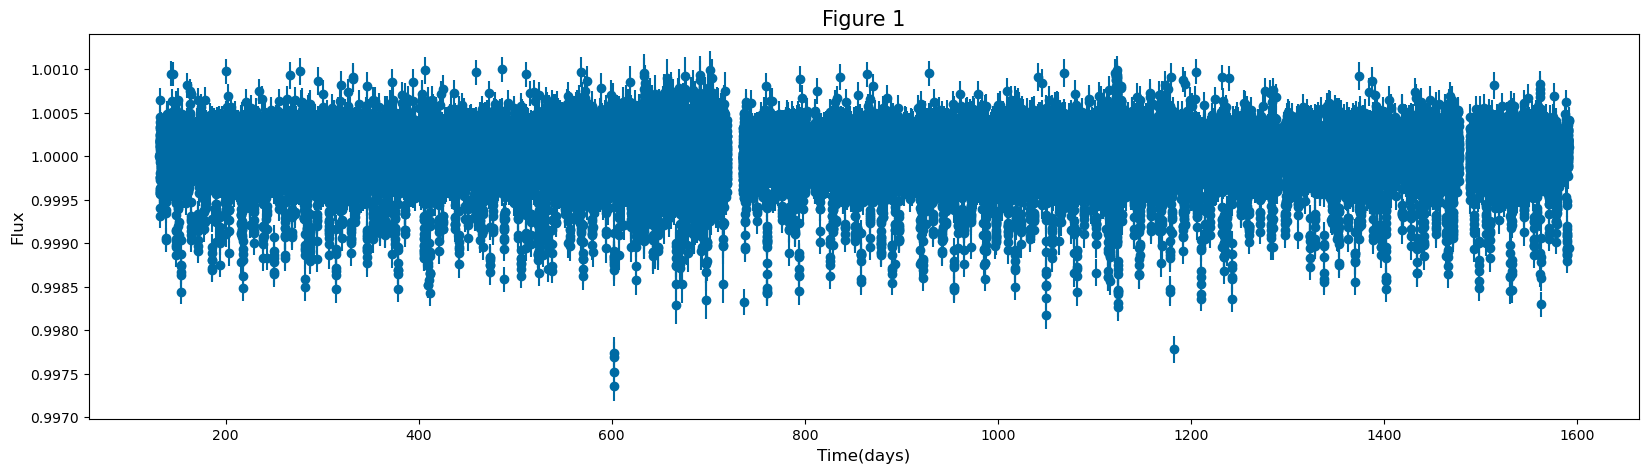

In [214]:
plt.figure(figsize = (20, 5))
plt.errorbar(time_array, flux_array, err_array, ls = 'none', marker = 'o')
plt.xlabel('Time(days)', size = 12)
plt.ylabel('Flux', size = 12)
plt.title("Figure 1", size = 15)

In [215]:
start = time_array[1] - time_array[0]
end = time_array[-1] - time_array[0]
end = 1469.5

print(end)

1469.5


In [216]:
#Shortest time scale in our data 

freqs = np.linspace(1/end,1/start, 20000)
lomb = scipy.signal.lombscargle(time_array, flux_array, freqs, precenter=True)


(0.0, 50.0)

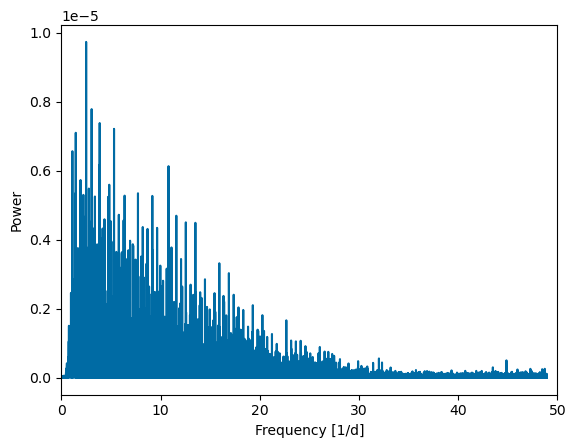

In [217]:
plt.plot(freqs, lomb)
plt.xlabel('Frequency [1/d]')
plt.ylabel('Power')
plt.xlim(0, 50)

In [218]:
period = np.linspace(1,200, 20000)
lomb2 = scipy.signal.lombscargle(freqs, lomb, period, precenter=True)

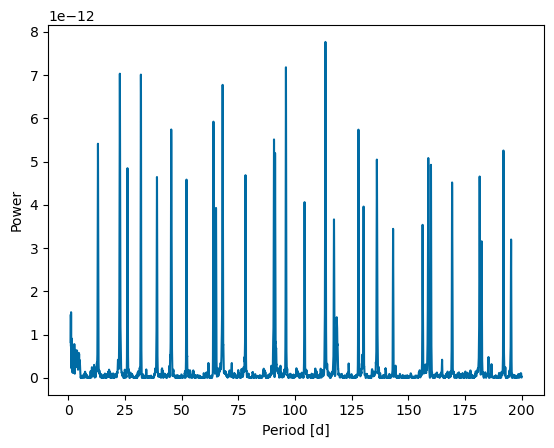

In [219]:
plt.plot(period, lomb2)
plt.xlabel('Period [d]')
plt.ylabel('Power')

freq1 = 13.025
freq2 = 22.687
freq3 = 31.996
freq4 = 118.37

array1 = np.arange(freq1, 200,freq1 )
array2 = np.arange(freq2, 200,freq2 )
array3 = np.arange(freq3, 200,freq3 )
array4 = np.arange(freq4, 200,freq4 )

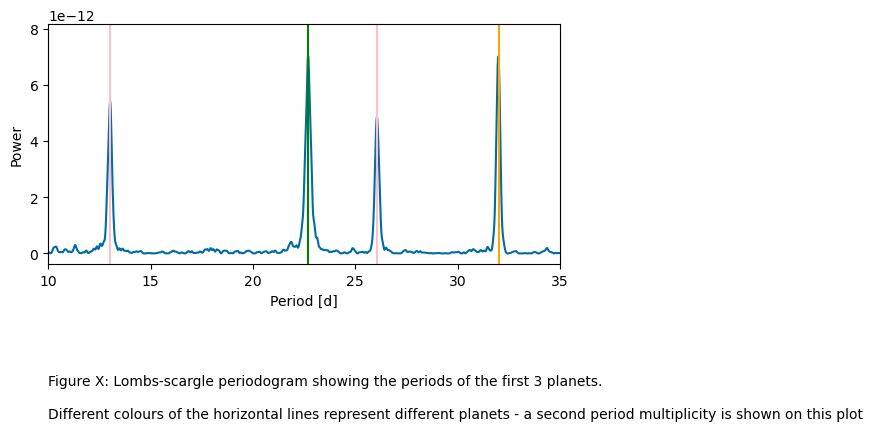

In [220]:
fig = plt.figure()
ax1 = fig.add_axes((.1,.4,.8,.5))

ax1.plot(period, lomb2)
ax1.set_xlabel('Period [d]')
plt.ylabel('Power')

for i in array1:
    plt.axvline(i, c='pink')
for i in array2:
    plt.axvline(i, c='green')
for i in array3:
    plt.axvline(i, c='orange')
for i in array4:
    plt.axvline(i, c='yellow')

plt.xlim(10, 35)

txt = '''Figure X: Lombs-scargle periodogram showing the periods of the first 3 planets. \n  
Different colours of the horizontal lines represent different planets - a second period multiplicity is shown on this plot'''

fig.text(.1,.08,txt)
plt.show()

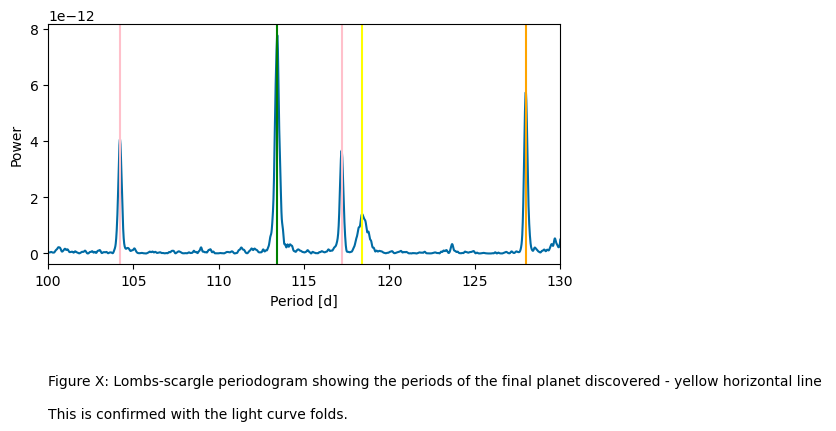

In [221]:
fig = plt.figure()
ax1 = fig.add_axes((.1,.4,.8,.5))

ax1.plot(period, lomb2)
ax1.set_xlabel('Period [d]')
plt.ylabel('Power')

for i in array1:
    plt.axvline(i, c='pink')
for i in array2:
    plt.axvline(i, c='green')
for i in array3:
    plt.axvline(i, c='orange')
for i in array4:
    plt.axvline(i, c='yellow')

plt.xlim(100, 130)

txt = '''Figure X: Lombs-scargle periodogram showing the periods of the final planet discovered - yellow horizontal line \n 
This is confirmed with the light curve folds.'''
fig.text(.1,.08,txt)
plt.show()

### Exoplanet 1

In [222]:
def fold_lightcurve(time, flux, error, period):
    """
    Folds the lightcurve given a period.
    time: input time (same unit as period)
    flux: input flux
    error: input error
    period: period to be folded to, needs to same unit as time (i.e. days)
    returns: phase, folded flux, folded error
    """
    #Create a pandats dataframe from the 
    data = pd.DataFrame({'time': time, 'flux': flux, 'error': error})
    
    #create the phase 
    data['phase'] = data.apply(lambda x: ((x.time/ period) - np.floor(x.time / period)), axis=1)
    
    #Creates the out phase, flux and error
    phase_long = np.concatenate((data['phase'], data['phase'] + 1.0, data['phase'] + 2.0))
    flux_long = np.concatenate((flux, flux, flux))
    err_long = np.concatenate((error, error, error))
    
    return(data['phase'], flux, error)

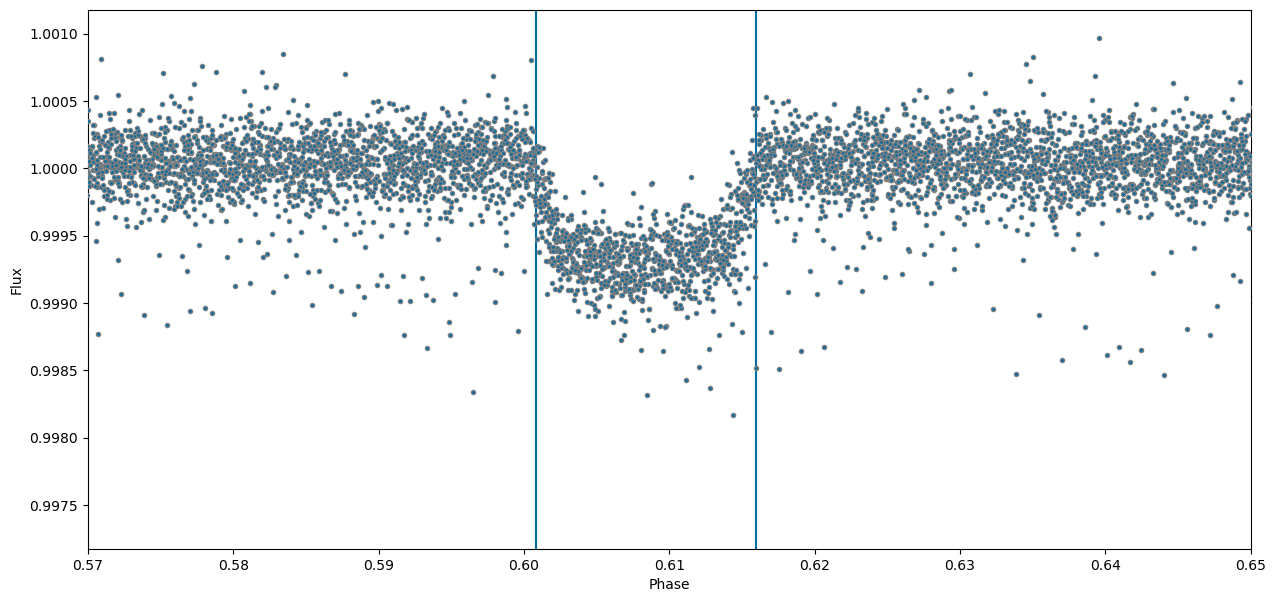

In [223]:
#First period - 13.025 days
plt.figure(figsize = (15, 7))
p1, p1_flux,p1_error = fold_lightcurve(time_array, flux_array, err_array,  13.025)
plt.plot(p1, p1_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey')

plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0.57, 0.65)
# cut off points for base level

p1_base_right = 0.616
p1_base_left = 0.6008
plt.axvline(p1_base_left)
plt.axvline(p1_base_right)
p1_dip_start = 0.604
p1_dip_end = 0.6125

Figure 1

In [224]:
#Difining a function to fit the transit dips 

#transit_fit is used to model the dips
"""def transit_fit(x, transit_end,transit_beginning , depth):
    y = (16*(1 - depth)/(transit_end - transit_beginning)**4) * (x - (transit_end + transit_beginning)/2)**4 +depth
    return (x>transit_beginning)*(x<transit_end)*y +(x<transit_beginning) + (x>transit_end)
"""
def transit_fit2(x, transit_end,transit_beginning , depth, base):
    y = (16*(1 - depth)/(transit_end - transit_beginning)**4) * (x - (transit_end + transit_beginning)/2)**4 +depth
    
    return (x>=transit_beginning)*(x<=transit_end)*y +(x<transit_beginning)*base + (x>transit_end)*base

def transit_fit(x, transit_end,transit_beginning , depth, base):
    y = (16*(1 - depth)/(transit_end - transit_beginning)**4) * (x - (transit_end + transit_beginning)/2)**4 +depth
    
    return y

#a simple horizontal line is used to fit the the base line flux of the star. 
def line(x, B):
    return B

def chi(y, error, ymodel):
    chi = np.sum((y-ymodel)**2/(error**2))
    return chi

#function to calculate the reduced chi squared of the fit
def reduced_chi(y, error, ymodel, no_points, free_params):
    chi = np.sum((y-ymodel)**2/error**2)
    return (chi)/ (no_points - free_params - 1)

def reduced_chi2(chi, no_points, free_params):
    return (chi)/ (no_points - free_params - 1)

In [225]:
def stepwise(x, data_time, data_flux, data_err, base_left, base_right, dip_start, dip_end):
    #you can create the masks with the start and stop but you will need different start stops for the base and the dips
    #but you will use the start and stop of the base for the step function
    #creating masks for the base level data 
    base_mask =(data_time < base_left)
    base_mask_2 =(data_time > base_right)
    
    index = 0
    for i in base_mask:
        if i != base_mask_2[index]:
            base_mask[index] = True
        index += 1
    
    base_t_data = data_time[base_mask]
    base_flux_data = data_flux[base_mask]
    base_err_data = data_err[base_mask]
    
    #creating masks for the time data
    dip_mask = (data_time > dip_start) & (data_time < dip_end)
    
    dip_t_data = data_time[dip_mask]
    dip_flux_data = data_flux[dip_mask]
    dip_err_data = data_err[dip_mask]
    
    #fitting lines to the base level data and the dip data
    
    param_base, var_base = curve_fit(line, base_t_data , base_flux_data)
    param_dip, var_dip = curve_fit(line, dip_t_data, dip_flux_data)

    chi_base = chi(base_flux_data, base_err_data, line(base_t_data, param_base))
    chi_dip = chi(dip_flux_data, dip_err_data, line(dip_t_data, param_dip))
    
    chi_sum = chi_base + chi_dip 
    no_points = len(base_t_data) + len(dip_t_data)
    
    chi_reduced = reduced_chi2(chi_sum, no_points, 1)
    #creating the function 
    y = []
    
    for i in x:
        
        if i <= base_left:
            y.append(param_base[0])
        elif i >= base_right:
            y.append(param_base[0])
        else:
            y.append(param_dip[0])

    y_new = np.array(y)
    return y_new, param_base, var_base, param_dip, var_dip, chi_reduced

Reduced Chi Squared =     2.1181


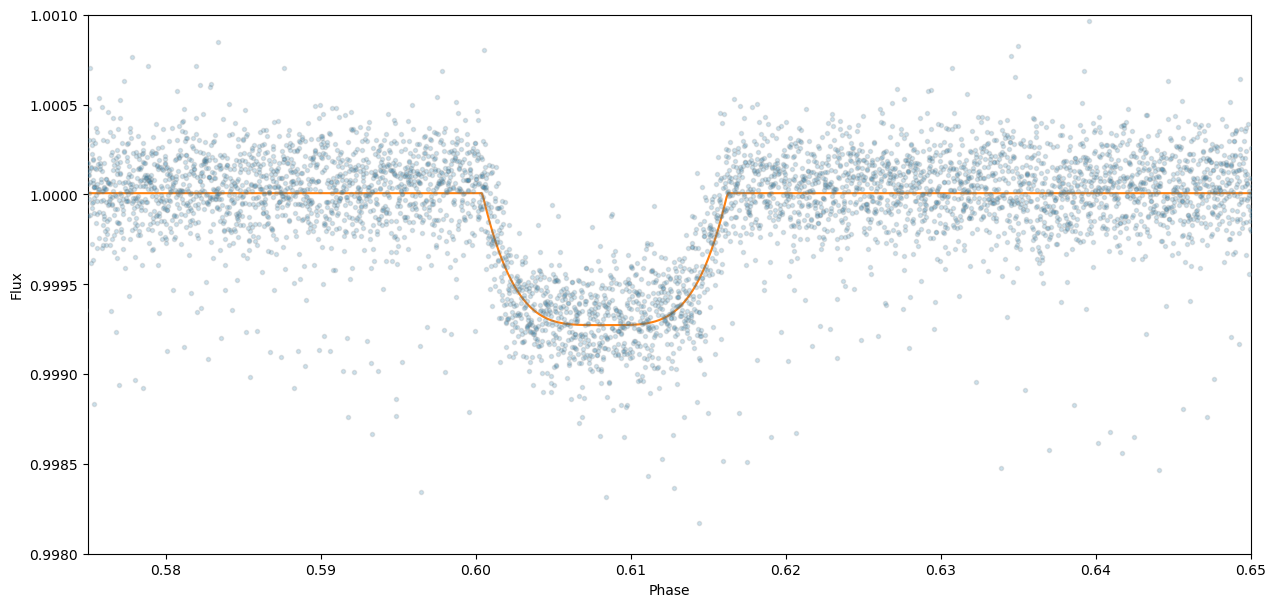

In [226]:
plt.figure(figsize = (15, 7))
mask = (p1 >p1_base_left)&(p1 <p1_base_right)
p1_mask = p1[mask]
p1_flux_mask = p1_flux[mask]
p1_error_mask = p1_error[mask]

#transit_fit(x, transit_end,transit_beginning , depth)

param, var = curve_fit(transit_fit2, p1, p1_flux, sigma= p1_error,\
                               p0=[max(p1_mask), min(p1_mask),0.993, 1])

x = np.arange(0, 1, 0.0001)
#x = p1_mask
y = transit_fit2(x, param[0], param[1], param[2], param[3])
#print(x)
plt.plot(p1, p1_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey', alpha = 0.2)
plt.plot(x, y)
plt.xlabel('Phase')
plt.ylabel('Flux')

plt.xlim(0.575, 0.65)
plt.ylim(0.998, 1.001)

#reduced_chi(p1_flux_mask, p1_error_mask,transit_fit(p1_mask, param[0], param[1], param[2]), len(p1_flux_mask), 3)
p1_quartic_chi = reduced_chi(p1_flux, p1_error,transit_fit2(p1, param[0], param[1], param[2], param[3]), len(p1_flux), 3)
print("Reduced Chi Squared = {:10.4f}".format(p1_quartic_chi))

[8.9767892e-06]
0.9993015434939551
2.116997324985263


(0.998, 1.001)

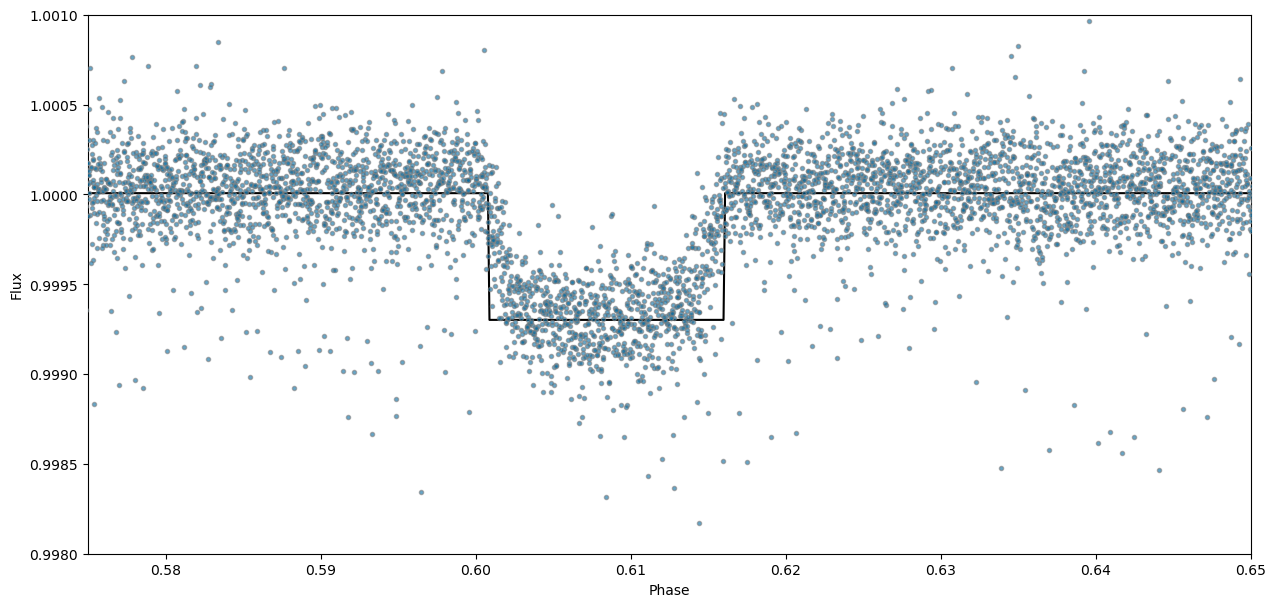

In [227]:
"""mask = (p1 >p1_base_left)&(p1 <p1_base_right)
p1_mask = p1[mask]
p1_flux_mask = p1_flux[mask]
p1_error_mask = p1_error[mask]
"""
x = np.arange(0.5, 0.7, 0.0001)
plt.figure(figsize = (15, 7))


#stepwise(x, data_time, data_flux, data_err, base_left, base_right, dip_start, dip_end)
step = stepwise(x, p1, p1_flux,p1_error, p1_base_left, p1_base_right, p1_dip_start, p1_dip_end)

plt.plot(x, step[0], color = 'black')
plt.plot(p1, p1_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey', alpha = 0.6)
plt.xlabel('Phase')
plt.ylabel('Flux')

p1_base = step[1][0]
p1_base_err= (np.sqrt(step[2][0]))
p1_trough2 = step[3][0]
p1_trough2_err = np.sqrt(step[4][0])
p1_chi_reduced = step[5]

print(p1_trough2_err)
print(p1_trough2)
print(p1_chi_reduced)

plt.xlim(0.575, 0.65)
plt.ylim(0.998, 1.001)


Reduced Chi Squared =     2.1181


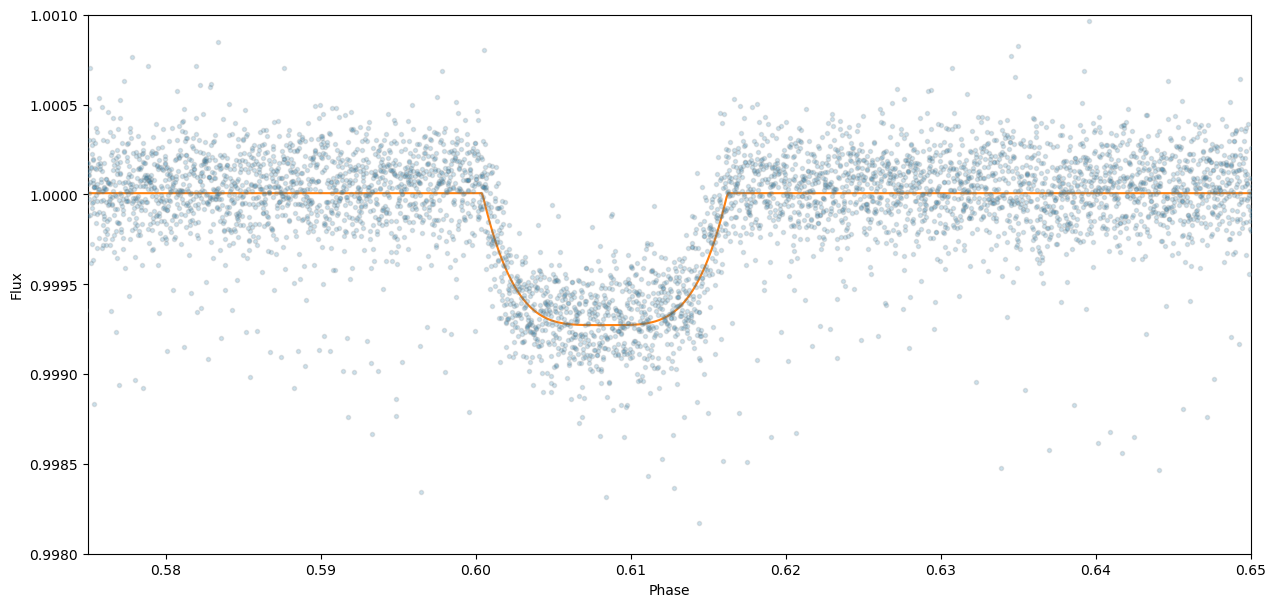

In [228]:
plt.figure(figsize = (15, 7))
mask = (p1 >p1_base_left)&(p1 <p1_base_right)
p1_mask = p1[mask]
p1_flux_mask = p1_flux[mask]
p1_error_mask = p1_error[mask]

#transit_fit(x, transit_end,transit_beginning , depth)

param, var = curve_fit(transit_fit2, p1, p1_flux, sigma= p1_error,\
                               p0=[max(p1_mask), min(p1_mask),0.993, 1])

x = np.arange(0, 1, 0.0001)
#x = p1_mask
y = transit_fit2(x, param[0], param[1], param[2], param[3])
#print(x)
plt.plot(p1, p1_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey', alpha = 0.2)
plt.plot(x, y)
plt.xlabel('Phase')
plt.ylabel('Flux')

plt.xlim(0.575, 0.65)
plt.ylim(0.998, 1.001)

p1_quartic_chi = reduced_chi(p1_flux, p1_error,transit_fit2(p1, param[0], param[1], param[2], param[3]), len(p1_flux), 3)
print("Reduced Chi Squared = {:10.4f}".format(p1_quartic_chi))

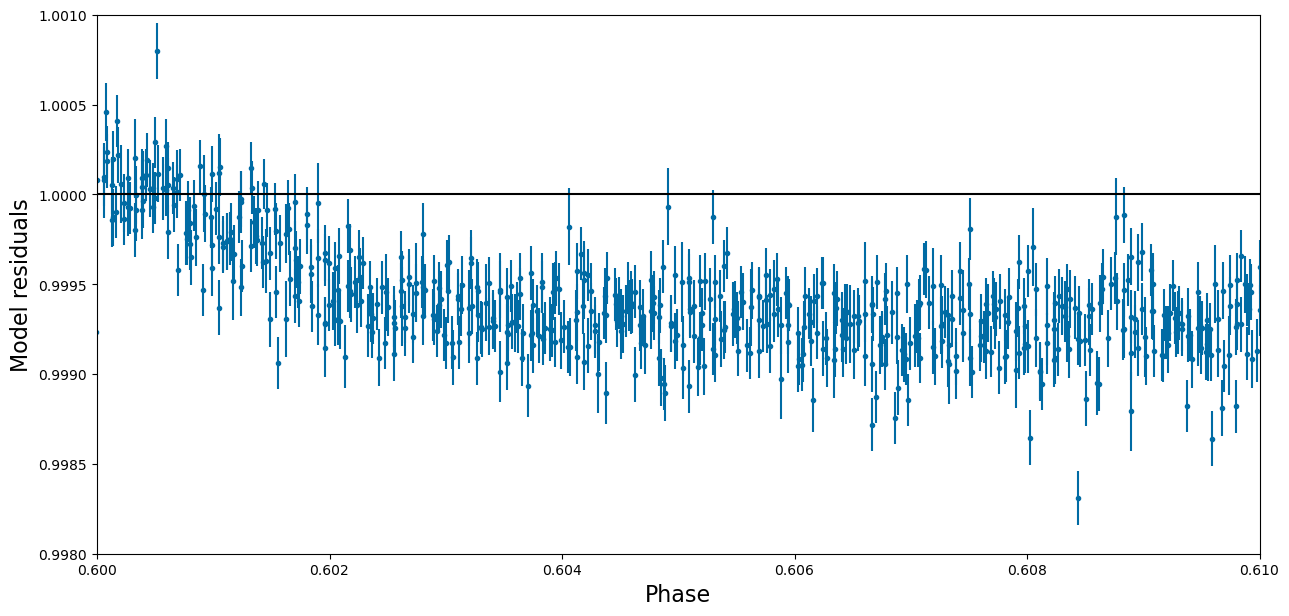

In [229]:
#Trying to plot the residuals of the model
import pylab
plt.figure(figsize = (15, 7))
# Let's check the residuals on the modelled mass-luminosity relation
pylab.xlabel(r'Phase',fontsize=16)
pylab.ylabel('Model residuals',fontsize=16)
p1_fit = transit_fit2(p1_flux, param[0], param[1], param[2], param[3])
pylab.errorbar(p1, p1_flux/p1_fit, p1_error/p1_fit,fmt='.',zorder=1)
plt.ylim(0.998, 1.001)
plt.xlim(0.6, 0.61)
pylab.plot([0,1], [1.0,1.0],c='k',zorder=2)

Looking at the above plot we can see that the fit underestimates some of the data in the transit dip portion. 

In [230]:
print(p1_fit)

[1.00000678 1.00000678 1.00000678 ... 1.00000678 1.00000678 1.00000678]


In [231]:
#extracting the key parameters from the above fit
p1_period = 13.025 #days
p1_period_err = 0.001
p1_end = param[0]
p1_start = param[1]
p1_trough = param[2]
p1_base = param[3]

p1_err = np.sqrt(np.diag(var))

p1_end_err = p1_err[0]
p1_start_err = p1_err[1]
p1_trough_err = p1_err[2]
p1_base_err = p1_err[3]

p1_transit_time = (p1_end - p1_start) *p1_period #days
p1_transit_time_err = (((p1_start_err + p1_end_err)/(p1_end - p1_start))+(p1_period_err/p1_period))*p1_transit_time


### Exoplanet 2

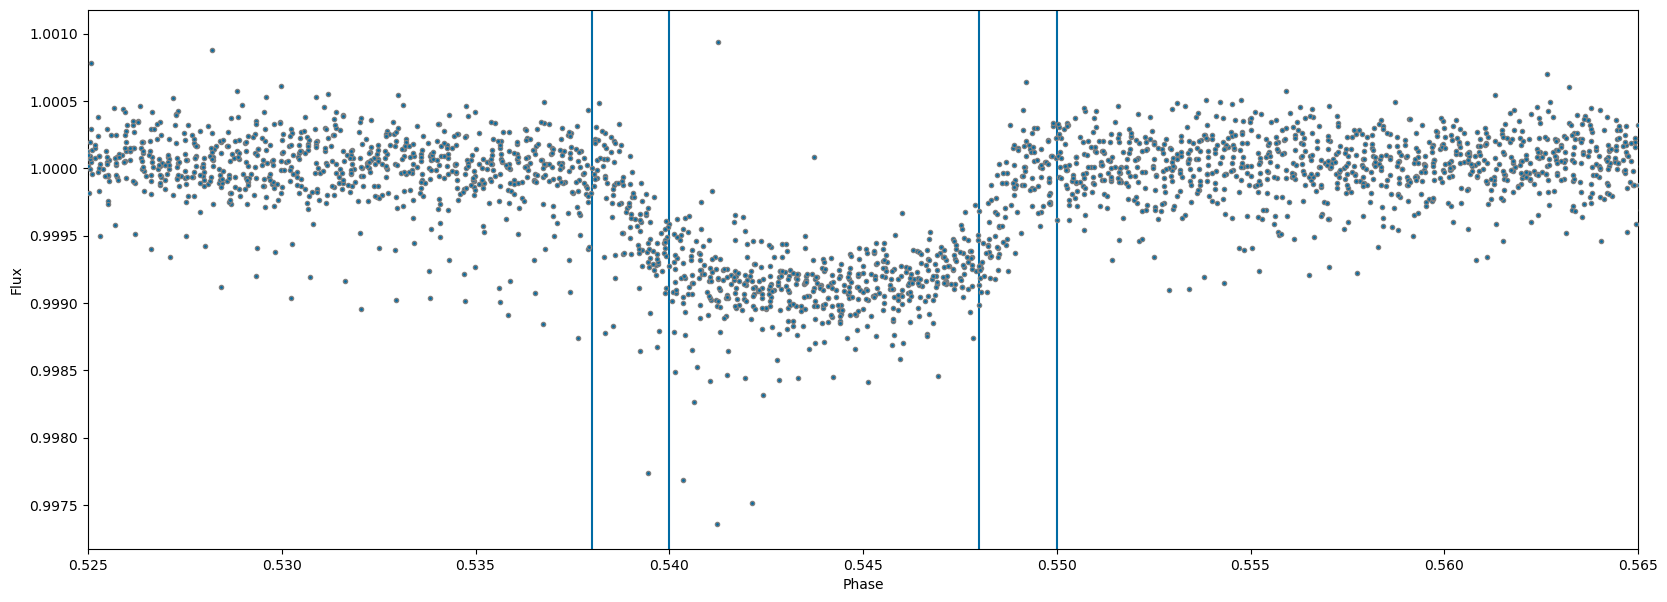

In [232]:
#Second period - 22.687
plt.figure(figsize = (20, 7))
p2, p2_flux,p2_error = fold_lightcurve(time_array, flux_array, err_array,  22.687)
plt.plot(p2, p2_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey')

plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0.525, 0.565)

p2_base_left = 0.538
p2_base_right = 0.550

plt.axvline(p2_base_left)
plt.axvline(p2_base_right)

p2_dip_start = 0.540
p2_dip_end = 0.548
plt.axvline(p2_dip_start)
plt.axvline(p2_dip_end)

0.5492021248697948 0.5382707509891349 0.9990887145693075


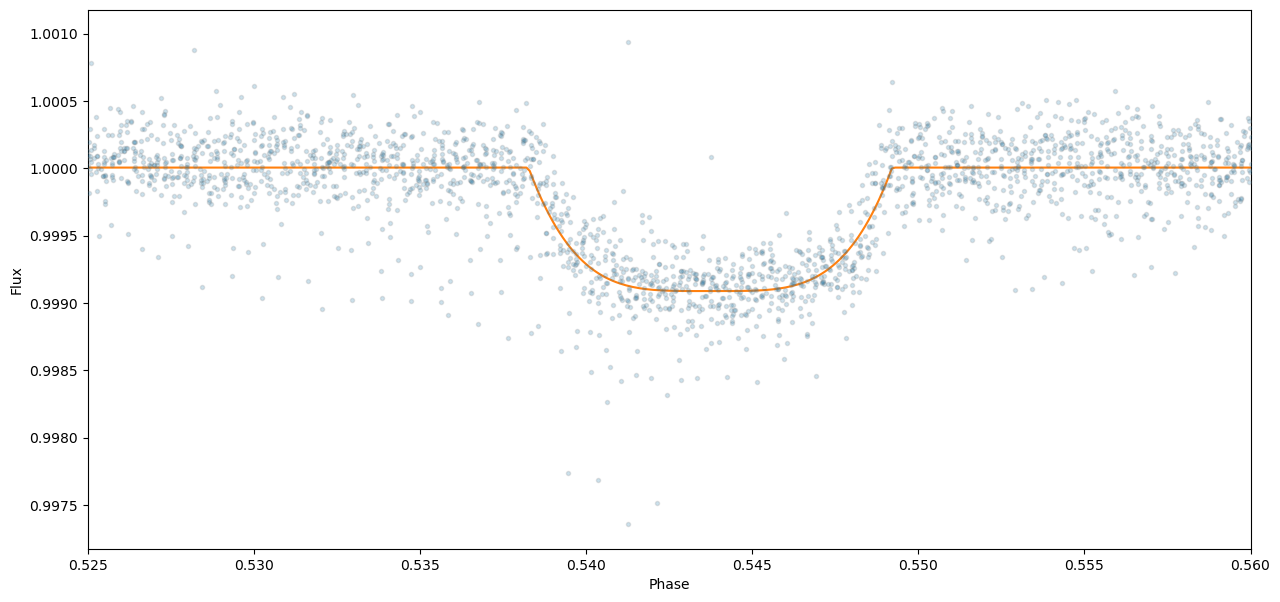

In [233]:
plt.figure(figsize = (15, 7))
mask = (p2 >p2_base_left)&(p2 <p2_base_right) #&(p2_flux >0.9980)
p2_mask = p2[mask]
p2_flux_mask = p2_flux[mask]
p2_error_mask = p2_error[mask]

param, var = curve_fit(transit_fit2, p2, p2_flux, sigma= p2_error,\
                               p0=[max(p2_mask), min(p2_mask),0.993, 1])

x = np.arange(0, 1, 0.0001)
y = transit_fit2(x, param[0], param[1], param[2], param[3])

plt.plot(p2, p2_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey', alpha = 0.2)
plt.xlim(0.525, 0.56)
plt.plot(x, y)
plt.xlabel('Phase')
plt.ylabel('Flux')

print(param[0], param[1], param[2])
p2_quartic_chi = reduced_chi(p2_flux, p2_error,transit_fit(p2, param[0], param[1], param[2], param[3]), len(p2_flux), 4)
#print(p2_quartic_chi)
#print("Reduced Chi Squared = {:1.4f}".format(p2_quartic_chi))

In [234]:
#extracting key parameters for exoplanet 2 
p2_period = 22.687#days
p2_period_err = 0.001
p2_end = param[0]
p2_start = param[1]
p2_trough = param[2]
p2_base = param[3]

p2_err = np.sqrt(np.diag(var))

p2_end_err = p2_err[0]
p2_start_err = p2_err[1]
p2_trough_err = p2_err[2]
p2_base_err = p2_err[3]

p2_transit_time = (p2_end - p2_start) *p2_period #days
p2_transit_time_err = (((p2_start_err + p2_end_err)/(p2_end - p2_start))+(p2_period_err/p2_period))*p2_transit_time


### Exoplanet 3 

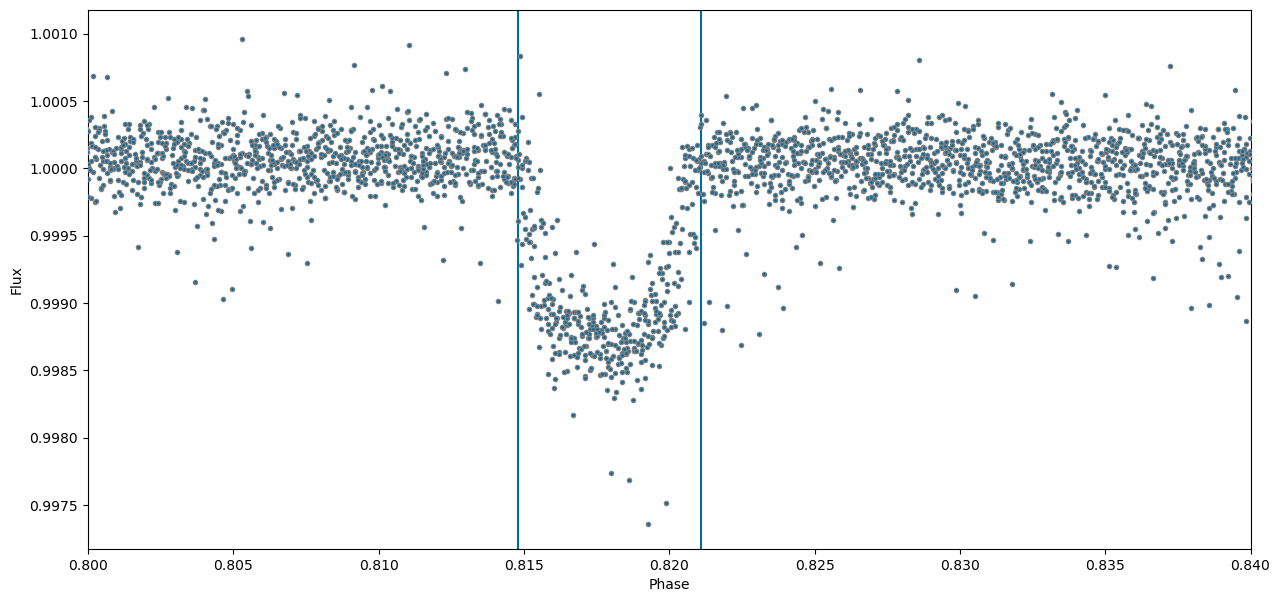

In [235]:
#Third period - 31.996
plt.figure(figsize = (15, 7))
p3, p3_flux,p3_error = fold_lightcurve(time_array, flux_array, err_array,  31.996)
plt.plot(p3, p3_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey')

plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0.8, 0.84)

p3_base_left = 0.8148
p3_base_right = 0.8211

plt.axvline(p3_base_left)
plt.axvline(p3_base_right)

p3_dip_start = 0.816
p3_dip_end = 0.8199
#plt.axvline(p3_dip_start)
#plt.axvline(p3_dip_end)

2.723743611877461e+20

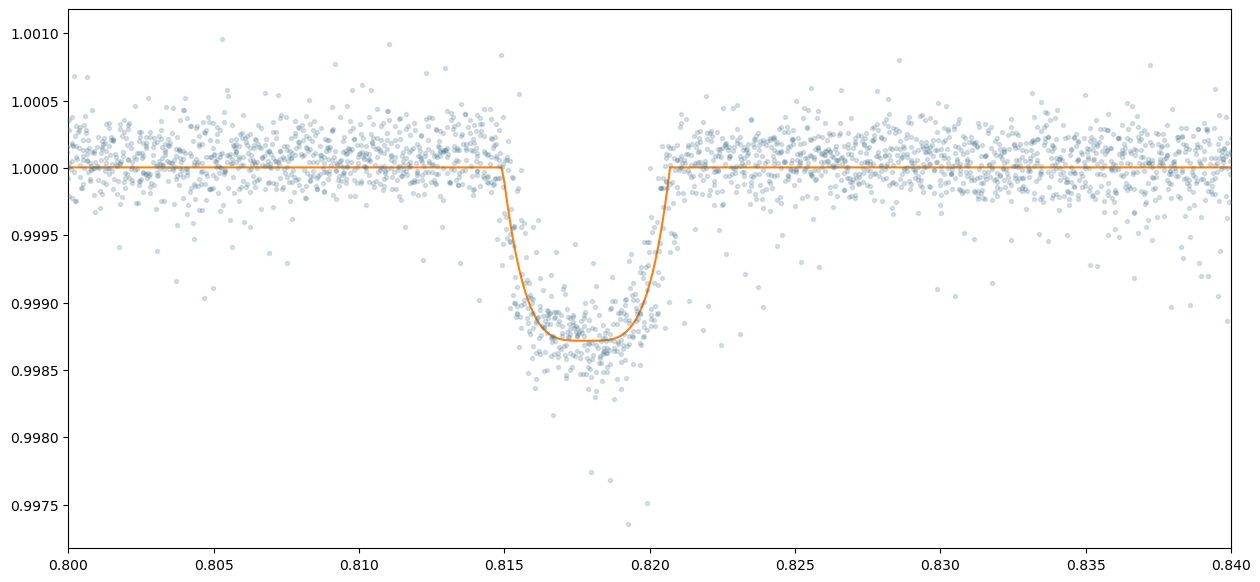

In [236]:
plt.figure(figsize = (15, 7))
mask = (p3 >p3_base_left)&(p3 <p3_base_right) #&(p2_flux >0.9980)
p3_mask = p3[mask]
p3_flux_mask = p3_flux[mask]
p3_error_mask = p3_error[mask]

param, var = curve_fit(transit_fit2, p3, p3_flux, sigma= p3_error,\
                               p0=[max(p3_mask), min(p3_mask),0.993, 1])

x = np.arange(0, 1, 0.0001)
y = transit_fit2(x, param[0], param[1], param[2], param[3])

plt.plot(p3, p3_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey', alpha = 0.2)


plt.plot(x, y)
plt.xlim(0.8, 0.84)

reduced_chi(p3_flux, p3_error,transit_fit(p3, param[0], param[1], param[2], param[3]), len(p3_flux), 4)

In [237]:
#extracting key parameters for exoplanet 3
p3_period = 31.996 #days
p3_period_err = 0.001
p3_end = param[0]
p3_start = param[1]
p3_trough = param[2]
p3_base = param[3]

p3_err = np.sqrt(np.diag(var))

p3_end_err = p3_err[0]
p3_start_err = p3_err[1]
p3_trough_err = p3_err[2]
p3_base_err = p3_err[3]

p3_transit_time = (p3_end - p3_start) *p3_period #days
p3_transit_time_err = (((p3_start_err + p3_end_err)/(p3_end - p3_start))+(p3_period_err/p3_period))*p3_transit_time


### Exoplanet 4

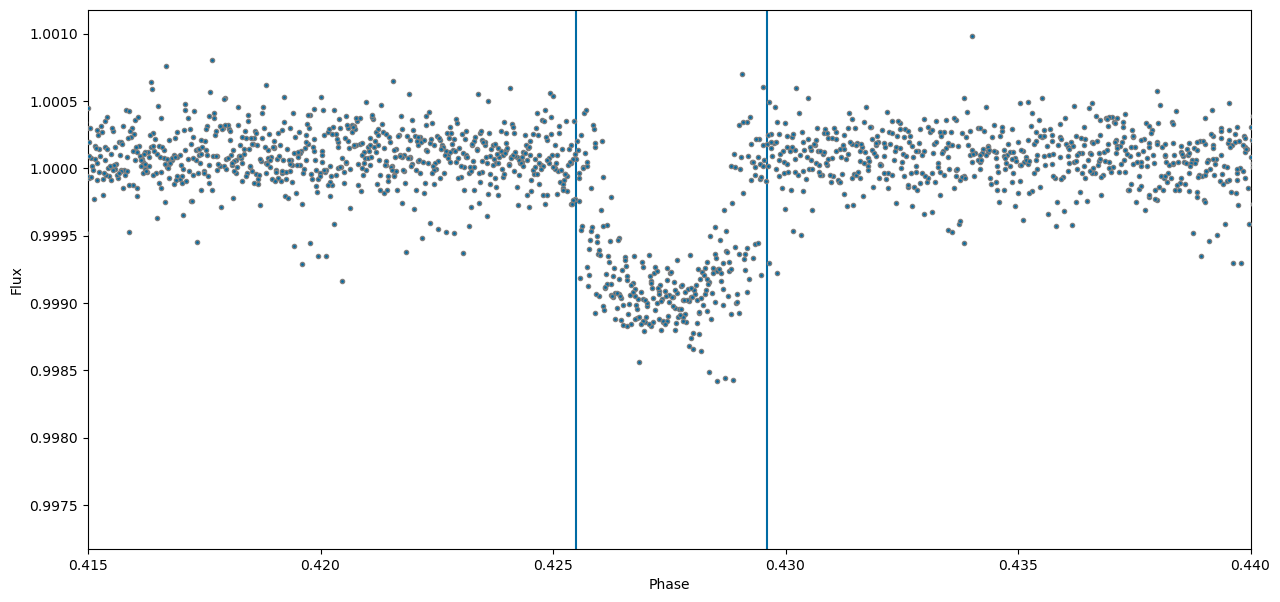

In [238]:
#Third period - 118.27
plt.figure(figsize = (15, 7))
p4, p4_flux,p4_error = fold_lightcurve(time_array, flux_array, err_array,  118.37)
plt.plot(p4, p4_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey')

plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0.415, 0.44)
#plt.xlim(0.42, 0.435)

p4_base_left = 0.4265
p4_base_right = 0.4285
#plt.axvline(p4_base_left)
#plt.axvline(p4_base_right)

p4_dip_start = 0.4255
p4_dip_end = 0.4296
plt.axvline(p4_dip_start)
plt.axvline(p4_dip_end)

2.722728157828184e+20

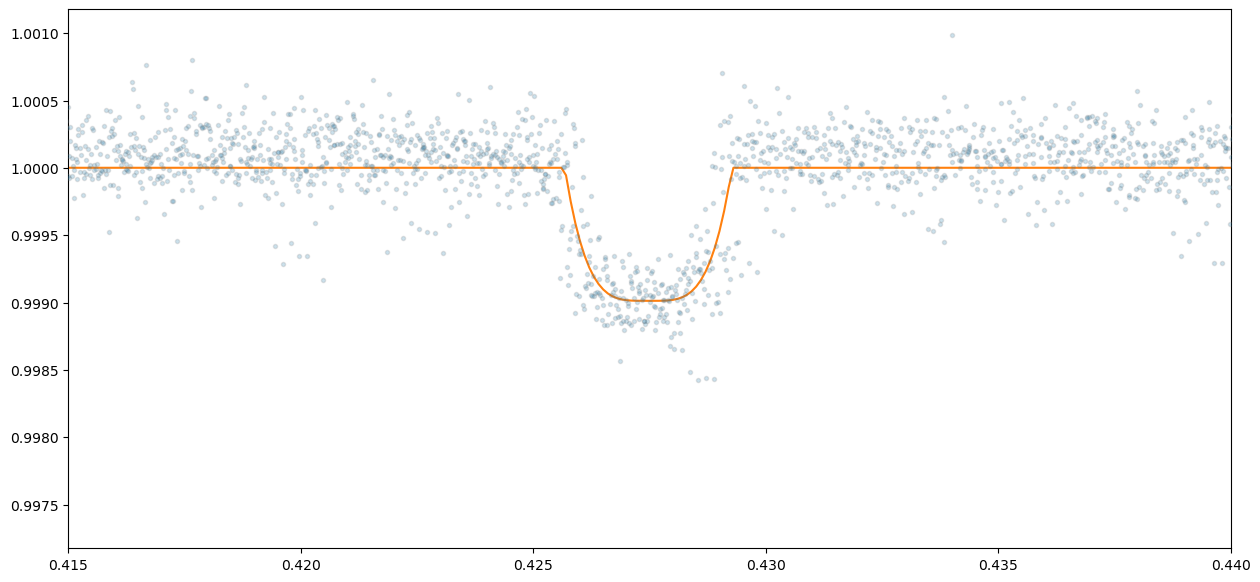

In [239]:
plt.figure(figsize = (15, 7))
mask = (p4 >p4_base_left)&(p4 <p4_base_right) #&(p2_flux >0.9980)
p4_mask = p4[mask]
p4_flux_mask = p4_flux[mask]
p4_error_mask = p4_error[mask]

param, var = curve_fit(transit_fit2, p4, p4_flux, sigma= p4_error,\
                               p0=[max(p4_mask), min(p4_mask),0.993, 1])

x = np.arange(0, 1, 0.0001)
y = transit_fit2(x, param[0], param[1], param[2], param[3])

plt.plot(p4, p4_flux, marker='.', ls='None', zorder=4, label='_nolegend_', mec='Grey', alpha = 0.2)


plt.plot(x, y)
plt.xlim(0.415, 0.44)

reduced_chi(p4_flux, p4_error,transit_fit(p4, param[0], param[1], param[2], param[3]), len(p4_flux), 4)

In [240]:
#extracting key parameters for exoplanet 4
p4_period = 118.27 #days
p4_period_err = 0.001
p4_end = param[0]
p4_start = param[1]
p4_trough = param[2]
p4_base = param[3]

p4_err = np.sqrt(np.diag(var))

p4_end_err = p4_err[0]
p4_start_err = p4_err[1]
p4_trough_err = p4_err[2]
p4_base_err = p4_err[3]

p4_transit_time = (p4_end - p4_start) *p4_period #days
p4_transit_time_err = (((p4_start_err + p4_end_err)/(p4_end - p4_start))+(p4_period_err/p4_period))*p4_transit_time


In [241]:
#Defining some key constants
solar_mass = 1.99 * 10**30
solar_mass_err = 0.01 * solar_mass
G = 6.6743*10**(-11)
solar_radius = 6.96*10**(8)
solar_radius_err = 0.01 * solar_radius 


class Key_Parameters:
    """This class contains functions for all key parameters in SI units"""
    def __init__(self, period, mass, mass_upper_err, mass_lower_err, depth, depth_err, base_flux,\
                 base_err, transit_time, transit_time_err):
            self.period = period #The period must be inputted in seconds
            self.mass = mass
            self.mass_upper_err = mass_upper_err
            self.mass_lower_err = mass_lower_err
            self.depth = depth
            self.depth_err = depth_err 
            self.base_flux = base_flux
            self.base_err = base_err
            self.transit_time = transit_time
            self.transit_time_err = transit_time_err

#need to add in the upper and lower errors for the masses to get an upper and a lower limit of the function
#this function outputs the semi major axis in m 
    def period_err(self):
        #This function outputs the fractional error of the period. 
        period = self.period
        return 0.001 / period

    def semi_major_axis(self):
        mass_planet = self.mass
        mass =  solar_mass + mass_planet #mass of the star + mass of the planet (might be able to just use the mass of the star)
        period = self.period
        period_err = self.period_err()
        
        sma = ((period**2*G*mass)/(4*np.pi**2))**(1/3)
        
        sma_error = ((2/3)*period_err + (1/3)*0.01)*sma
        
        return sma, sma_error
    
    def radius(self):
        depth = self.depth
        depth_err = self.depth_err
        base = self.base_flux
        base_err = self.base_err
        
        radius = ((depth/base)*solar_radius**2)**(1/2)
        radius_err = ((1/2)* (depth_err/depth)+(1/2) * (base_err/ base) + (0.01)) * radius
        return radius, radius_err

    def orbital_vel(self):
        sma = self.semi_major_axis()[0]
        sma_err = self.semi_major_axis()[1]
        vel = np.sqrt((G*solar_mass)/sma)
        err = ((sma_err / sma) + 0.01) * vel
        return vel, err

    def orbital_vel2(self):
        period = self.period
        period_err = self.period_err()
        sma = self.semi_major_axis()[0]
        sma_err = self.semi_major_axis()[1]
        
        vel = (2*np.pi*(sma))/ period
        err = (2 * (sma_err/ sma) + (period_err/period))*vel
        
        return vel, err

    #what we expect the transit time to be - page 19 of the notes - if this does not match up to what is seen then there must be an inclination 
    def transit_time_est(self):
        period = self.period
        period_err = self.period_err()
        sma = self.semi_major_axis()[0]
        sma_err = self.semi_major_axis()[1]
        
        t = (period*solar_radius)/((np.pi)*sma)
        t_err = ((period_err/period) + 0.01 + (sma_err/sma))*t
        
        return t, t_err
    
    def inclination(self):
        #I don't think this is right 
        tt = self.transit_time
        sma = self.semi_major_axis()[0]
        p = self.period
        r_p = self.radius()[0]
        #calculates the inclination - assuming a circular orbit
        cos_theta = (((tt * np.pi * sma)/p)- r_p)/solar_radius
        theta = np.arccos(cos_theta)
        return theta
    
    def transit_time_est2(self):
        period = self.period
        period_err = self.period_err()
        sma = self.semi_major_axis()[0]
        sma_err = self.semi_major_axis()[1]
        rad = self.radius()[0]
        rad_err = self.radius()[1]
        
        t = (period / np.pi) * np.arcsin((np.sqrt((solar_radius + rad)**2))/sma)
        return t
        
    
    def impact_parameter(self):
        inc = self.inclination()
        sma = self. semi_major_axis()[0]
        
        b = (sma * np.cos(inc))/solar_radius 
        return b
    
    def impact_parameter2(self):
        period = self.period
        period_err = self.period_err()
        sma = self.semi_major_axis()[0]
        sma_err = self.semi_major_axis()[1]
        rad = self.radius()[0]
        rad_err = self.radius()[1]
        tt = self.transit_time
        
        b = np.sqrt((solar_radius + rad)**2 - (sma * np.sin(tt*np.pi / period))**2)/solar_radius 
        return b
        

        
    def transit_prob(self):
        """This calculates the transit probability based on radius and semi-major axis"""
        sma = self.semi_major_axis()[0]
        return solar_radius / sma #could include planet radius if wanted 

    def density(self):
        """density in kg/m^3"""
        mass_u = self.mass_upper_err
        mass_l = self.mass_lower_err
        mass = self.mass
        
        rad = self.radius()[0]
        rad_err = self.radius()[1]
        vol = (4/3)*np.pi*rad**3
        density = mass / vol 
        density_err = (rad_err/rad) * density
        density_u =(mass + mass_u)/vol
        density_u_err = (rad_err/rad) * density_u
        density_l =(mass- mass_l)/vol 
        density_l_err = (rad_err/rad) * density_l
        
        return density, density_err, density_u, density_u_err, density_l, density_l_err

In [242]:
#1
#Extracting Key exoplanet properties 
earth_mass = 5.972 *10**24 #kg
jupiter_mass = 1.898 * 10**27 #kg
earth_radius = 6.371 * 10 ** 6 #m

p1_period = 13.025 * 24 * 60 * 60 #seconds 
p1_mass = 2.9 * earth_mass #Obtained by private communications with Villforth
p1_mass_up_error = 2.9 * earth_mass
p1_mass_down_error = 1.6 * earth_mass
p1_depth = p1_base - p1_trough
p1_depth_error = p1_base_err + p1_trough_err
p1_transit_time_s = p1_transit_time *24 *60*60 

p1_params = Key_Parameters(p1_period , p1_mass, p1_mass_up_error, p1_mass_down_error, p1_depth, p1_depth_error,\
                           p1_base, p1_base_err, p1_transit_time, p1_transit_time_err)
#Semi-Major-Axis
p1_sma_AU = p1_params.semi_major_axis()[0] * 6.6846 * 10 ** (-12) # 0.108 AU
p1_sma_AU_err = p1_params.semi_major_axis()[1] * 6.6846 * 10 ** (-12) #0.00036 AU

#Mass
p1_mass_jup = p1_mass / jupiter_mass #0.00912 jup_mass

#Radius
p1_rad = p1_params.radius()[0] / earth_radius #2.96 earth rads
p1_rad_err = p1_params.radius()[1] / earth_radius

#Density
p1_d = p1_params.density() #(density, density_err, density_u, density_u_err, density_l, density_l_err)
p1_density = [] #converting density to g / cm^3 
for output in p1_d:
    p1_density.append(output/1000)
    
#Transit Probability
p1_transit_probability = p1_params.transit_prob()

#Transit Time 
#p1_transit_time_est = p1_params.transit_time_est()
p1_transit_time_est2 = p1_params.transit_time_est2()


#Inclination + impact parameter
#p1_inc = p1_params.inclination()
p1_b = p1_params.impact_parameter()

p1_b2 = p1_params.impact_parameter2()

#print(p1_transit_time_est[0]/(60 *60 ))
print(p1_transit_time_est2/(60 *60 ))
#print(p1_transit_time_s/(60 *60 ) )
#print(p1_transit_probability)

print(p1_b2)
print(p1_b)


4.389080039090293
1.0271004418380745
-0.6309303762903532


In [243]:
#Testing the new functions to figure out what's wrong 

p1_sma = p1_params.semi_major_axis()[0]

def inclination(tt, sma, p, rp):
        #I don't think this is right 
        #calculates the inclination - assuming a circular orbit
        cos_theta = (((tt * np.pi * sma)/p)- rp)/solar_radius
        theta = np.arccos(cos_theta)
        return theta
    
    
poo = inclination(p1_transit_time, p1_sma, p1_period, p1_rad)
print(np.rad2deg(poo))

print(p1_params.radius()[0])
print(p1_transit_time)
print(p1_transit_time_s/(60*60))
print(p1_sma)
print(p1_period/(60*60*24))
print(p1_rad)

89.99923426526702
18861907.579855446
0.20559671193663498
4.934321086479239
16211701449.475948
13.025
2.9605882247457926


In [244]:
#2
#Extracting Key exoplanet properties 
p2_period = 22.687 * 24 * 60 * 60 #seconds 
p2_mass = 7.3 * earth_mass #Obtained by private communications with Villforth
p2_mass_up_error = 0.8 * earth_mass
p2_mass_down_error = 1.5 * earth_mass
p2_depth = p1_base - p1_trough
p2_depth_error = p1_base_err + p1_trough_err
p2_transit_time_s = p2_transit_time * (24 * 60 * 60 )

p2_params = Key_Parameters(p2_period , p2_mass,p2_mass_up_error,p2_mass_down_error ,p2_depth,\
                           p2_depth_error, p2_base, p2_base_err,p2_transit_time_s, p2_transit_time_err)

#Semi-Major-Axis 
p2_sma_AU = p2_params.semi_major_axis()[0] * 6.6846 * 10 ** (-12) # 0.157 AU
p2_sma_AU_err = p2_params.semi_major_axis()[1] * 6.6846 * 10 ** (-12) #0.00052 AU
p2_mass_jup = p2_mass / jupiter_mass #0.0229

p2_vel = p2_params.orbital_vel()[0]
p2_vel2 = p2_params.orbital_vel2()[0]

#Radius 
p2_rad = p2_params.radius()[0] / earth_radius #2.96 earth rads
p2_rad_err = p2_params.radius()[1] / earth_radius

#Density
p2_d = p2_params.density() #(density, density_err, density_u, density_u_err, density_l, density_l_err)
p2_density = [] #converting density to g / cm^3 
for output in p2_d:
    p2_density.append(output/1000)
    
#Transit Probability
p2_transit_probability = p2_params.transit_prob()

#Transit Time 
p2_transit_time_est = p2_params.transit_time_est()
p2_transit_time_est2 = p2_params.transit_time_est2()

#Inclination + impact parameter
p2_inc = p1_params.inclination()
p2_b = p1_params.impact_parameter()

print(p2_transit_time_est)
print(p2_transit_time_est2)
print(p2_transit_time_s)

(18503.48130219412, 246.71309032245742)
19007.874125558606
21427.206845517892


In [245]:
#3
#Extracting Key exoplanet properties 
p3_period = 31.996 * 24 * 60 * 60 #seconds 
p3_mass = 8.8 * earth_mass #Obtained by private communications with Villforth
p3_mass_up_error = 1.5 * earth_mass
p3_mass_down_error = 2.1 * earth_mass
p3_depth = p3_base - p3_trough
p3_depth_error = p1_base_err + p1_trough_err

#def __init__(self, period, mass, depth, depth_err, base_flux, base_err, transit_time, transit_time_err)
p3_params = Key_Parameters(p3_period , p3_mass,p3_mass_up_error,p3_mass_down_error ,p3_depth, p3_depth_error, \
                           p3_base, p3_base_err, p3_transit_time, p3_transit_time_err)

p3_sma_AU = p3_params.semi_major_axis()[0] * 6.6846 * 10 ** (-12) # 0.197 AU
p3_sma_AU_err = p3_params.semi_major_axis()[1] * 6.6846 * 10 ** (-12) #0.00066 AU
p3_mass_jup = p3_mass / jupiter_mass #0.0277

p3_vel = p3_params.orbital_vel()[0]
p3_vel2 = p3_params.orbital_vel2()[0]


p3_rad = p3_params.radius()[0] / earth_radius #3.92 earth rads
p3_rad_err = p3_params.radius()[1] / earth_radius

#Density
p3_d = p3_params.density() #(density, density_err, density_u, density_u_err, density_l, density_l_err)
p3_density = [] #converting density to g / cm^3 
for output in p3_d:
    p3_density.append(output/1000)
    
#Transit Probability
p3_transit_probability = p3_params.transit_prob()

#Transit Time 
p3_transit_time_est = p3_params.transit_time_est()


In [246]:
#4
#Extracting Key exoplanet properties 
p4_period = 118.27 * 24 * 60 * 60 #seconds 
p4_mass = 25 * earth_mass #Obtained by private communications with Villforth
p4_mass_up_error = 0
p4_mass_down_error = 0
p4_depth = p4_base - p4_trough
p4_depth_error = p4_base_err + p4_trough_err

#def __init__(self, period, mass, depth, depth_err, base_flux, base_err, transit_time, transit_time_err)
p4_params = Key_Parameters(p4_period , p4_mass, p4_mass_up_error, p4_mass_down_error, p4_depth, p4_depth_error, \
                           p4_base, p4_base_err, p4_transit_time, p4_transit_time_err)

p4_sma_AU = p4_params.semi_major_axis()[0] * 6.6846 * 10 ** (-12) # 0.197 AU
p4_sma_AU_err = p4_params.semi_major_axis()[1] * 6.6846 * 10 ** (-12) #0.00066 AU
p4_mass_jup = p4_mass / jupiter_mass #0.0277

p4_vel = p4_params.orbital_vel()[0]
p4_vel2 = p4_params.orbital_vel2()[0]


p4_rad = p4_params.radius()[0] / earth_radius #3.43 earth rads
p4_rad_err = p4_params.radius()[1] / earth_radius


#Density
p4_d = p4_params.density() #(density, density_err, density_u, density_u_err, density_l, density_l_err)
p4_density = [] #converting density to g / cm^3 
for output in p4_d:
    p4_density.append(output/1000)
    
#Transit Probability
p4_transit_probability = p4_params.transit_prob()

#Transit Time 
p4_transit_time_est = p4_params.transit_time_est()

In [247]:
import pandas as pd

df = pd.DataFrame({
    "Planet Name": ["Planet 1", "Planet 2", "Planet 3", "Planet 4", "Earth", "Neptune"],
    "Planet Period $[days]$": [13.025, 22.687, 31.996, 118.27, 365, "60,190"],
    "Semi-Major-Axis $[AU]$": ["0.108 $\pm$ 0.00036", "0.157 $\pm$ 0.00052", "0.197 $\pm$ 0.00066", "0.47 $\pm$ 0.0016", 1, 30.1],     
    "Planet Mass [$M_{earth}$]": ["2.9 + 2.9 - 1.6 ", "7.3 + 0.8 - 1.5", "8.8 + 1.5 - 2.1", "< 25", "1", 17.15],
    "Transit times [hours]": ["$4.93 \pm 0.05$", "$5.95 \pm 0.06$", "$4.42 \pm 0.0$", "$10.20 \pm 0.15$", "$12.97$", "$122.2$" ],
    "Radius [Earth R]": ["$2.96 \pm 0.05$", "$2.96 \pm 0.05$", "$3.92 \pm 0.05$", "$3.43 \pm 0.07$", "$1$", "$3.88$" ],
    "Density [$g/cm^3$]": ["0.62 + 0.62 - 0.34", "1.55 + 0.17 - 0.32", "0.81 + 0.14 - 0.19", "< 3.4", "5.52", 1.638]
})

def make_pretty(styler):
    styler.set_caption("Table 1: Key properties derived of the 4 exoplanets derived from transit light curve\
    measurements. Errors are calculated through standard error propagation techniques and where the parameter\
    is obtained from the fit, errors are taken from the covarience matrix of the fit. Parameters of Earth and Neptune\
    are added for reference.")
    styler.format(precision=3, thousands=",", decimal=".") 
    return styler                  

df.style.pipe(make_pretty)

,Planet Name,Planet Period $[days]$,Semi-Major-Axis $[AU]$,Planet Mass [$M_{earth}$],Transit times [hours],Radius [Earth R],Density [$g/cm^3$]
0,Planet 1,13.025,0.108 $\pm$ 0.00036,2.9 + 2.9 - 1.6,$4.93 \pm 0.05$,$2.96 \pm 0.05$,0.62 + 0.62 - 0.34
1,Planet 2,22.687,0.157 $\pm$ 0.00052,7.3 + 0.8 - 1.5,$5.95 \pm 0.06$,$2.96 \pm 0.05$,1.55 + 0.17 - 0.32
2,Planet 3,31.996,0.197 $\pm$ 0.00066,8.8 + 1.5 - 2.1,$4.42 \pm 0.0$,$3.92 \pm 0.05$,0.81 + 0.14 - 0.19
3,Planet 4,118.270,0.47 $\pm$ 0.0016,< 25,$10.20 \pm 0.15$,$3.43 \pm 0.07$,< 3.4
4,Earth,365,1,1,$12.97$,$1$,5.52
5,Neptune,"60,190",30.100,17.150,$122.2$,$3.88$,1.638


### 3. Discussion


In [248]:
#Transit Time of earth if viewed head on and assuming circular orbit. 

def transit_time_est(period, sma):
        
    t = (period*solar_radius)/((np.pi)*sma)
        
    return t

transit_time_est(365 * 24 *60 *60, 1.496 * 10 ** 11)/(60 *60) #Earth
transit_time_est(60190 * 24 * 60 * 60, 17.5 * 1.496 * 10 ** 11)/(60*60) #Neptune
transit_time_est(88 * 24 *60*60, 0.387 * 1.496 * 10 ** 11)/(60*60) #Mercury 

8.081848820206778

This section discusses the classification of the four planets based on their properties and a model as to how these planets may have formed, providing a comparison to the currently discovered planets in the exoplanet zoo. When doing this and seeing how rare the finds of our planets are we should take into account the selection effects as outlined in the introduction. The planet formation of an exoplanet can, in general can be guessed by observing a plot of the mass to the semi-major axis.  

See table 1 for the key parameters of the discovered planets and how they compare to that of Earth and Neptune in our solar system. 

#### 3.1 Planet Classification 

The masses of 1, 2, and 3 are in the correct area to be termed 'super-earth' as they have a higher mass than that of earth. However one must note that this does not imply that that the planets are in the habitable zone, or that they can be classified as rocky planets. In some literature the term super earth is also given to planets which have a radius of a maximum of 1.6 times that of earth - but this is not the case for this system and the term only refers to its mass. 

All of the planets' sizes can be compared to that of neptune which has a radius of around 3.88 earth radii, but all the planets are still smaller than this, and hence the planets can be classified as 'Mini-Neptunes'. However the densities of the first 3 planets are really low suggesting that they don't don't have much of a rocky core and that they are mainly composed of gas. Planet 4 has a higher density than the others but is not as dense as earth, suggesting that it also has a significant gaseous atmosphere. 

There is a name coined for such 'mini-neptunes' with low densities - puffy planets [5]. All the planets are quite close to the sun, all of them are closer to the host star than venus (0.723 AU) and the first 3 planets are even closer to the host star than mercury (0.387 AU) - this type of proximity to the star would usually suggest very little to no atmosphere like mercury, as the solar winds would blow off the atmosphere. However, the larger size and mass of the planet and low density suggests that it must have enough gravitational force to hold onto an atmosphere. NASA suggests that these 'puffy planets' may be losing gaseous mass to the star and this explains a gap in the observed sizes of stars as they range from super-earth sizes with a maximum of 1.6 earth eadii and sizes of mini-neptunes with a size range of 2-4 times that of earth. The gap in sizes between 1.6 and 2 could be explained by planets quickly transitioning from one to another as a gaseous atmosphere of primarily hydrogen and helium is being stripped by x-rays and ultraviolent radiation in the time-scale of hundreds of millions of years - a time scale which is relatively short in comparison to the lifetime of the planet - hance planets of sizes in the gap are relatively rare to find. 

All these planets are so close to the star which also implies a high surface temperature which does not lie in the habitable zone for water to remain a liquid. 

#### Mass-Radius relationship 

In [249]:
import pandas as pd
exodata = pd.read_csv("ExoplanetArchiveData.csv", delimiter = ',', header = 147)
exodata_transit = exodata[exodata['discoverymethod'] == "Transit"]
exodata_kepler = exodata[exodata['pl_name'].str.contains('Kepler')]
exodata_puff_filter = exodata[(exodata['pl_dens'] <= 1) & (exodata['pl_orbsmax'] <= 0.5)]

/tmp/ipykernel_140/2861824767.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exodata = pd.read_csv("ExoplanetArchiveData.csv", delimiter = ',', header = 147)


In [250]:
#Earth radius to Jupiter radius 
p1_mass_e = p1_mass / earth_mass
p2_mass_e = p2_mass / earth_mass
p3_mass_e = p3_mass / earth_mass
p4_mass_e = p4_mass / earth_mass

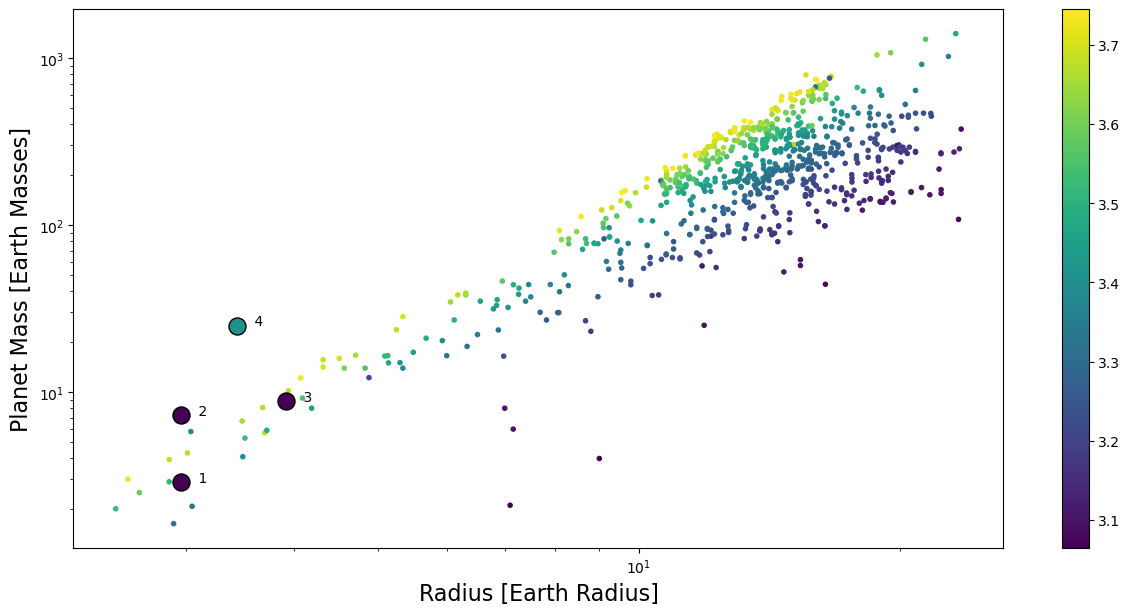

In [251]:
#Mass Radius Plot 
#Select all mini-neptune planets. 
#density < 1, sma < 0.5 

data = exodata_puff_filter

e_masses = data['pl_masse']
e_rads = data['pl_rade']
density = data['pl_dens']


plt.figure(figsize = (15, 7))
plt.style.use('tableau-colorblind10')


plt.scatter(e_rads, e_masses, ls = 'None', marker = '.' , c = density)
plt.scatter(p1_rad, p1_mass_e,  marker = 'o',s= 150, edgecolors = 'Black', c= p1_density[0])
plt.scatter(p2_rad, p2_mass_e,  marker = 'o',s= 150, edgecolors = 'Black', c= p2_density[0])
plt.scatter(p3_rad, p3_mass_e,  marker = 'o',s= 150, edgecolors = 'Black', c= p3_density[0])
plt.scatter(p4_rad, p4_mass_e,  marker = 'o',s= 150, edgecolors = 'Black', c= p4_density[0])
plt.text(p1_rad, p1_mass_e, '    1', ha = 'left')
plt.text(p2_rad, p2_mass_e, '    2', ha = 'left')
plt.text(p3_rad, p3_mass_e, '    3', ha = 'left')
plt.text(p4_rad, p4_mass_e, '    4', ha = 'left')

#plt.plot(e_rads_new, linfit(e_rads_new,a),c='k',zorder=2,label='Model')

plt.xlabel('Radius [Earth Radius]', fontsize = 16)
plt.ylabel('Planet Mass [Earth Masses]', fontsize = 16)
plt.yscale('log')
plt.xscale('log')

plt.colorbar()



The above figure shows a log log plot of the planet mass and the radius for planets with a density less than 1 grams per cubic meter and with a semi-major axis less than 0.5 AU - these parameters were chosen in order to only select low density super earth's with short periods. Looking at the data there seems to be a correlation between the mass and radius of these two variables.

In order to test if there is a correlation between these two variables, Spearmans Rank correlation test is used. 

In [252]:
def linfit(xdata, a ,c):
    return xdata*a + c

Nan_rads = ~np.isnan(e_rads) 
Nan_masses = ~np.isnan(e_masses)

e_rads_new =e_rads[(Nan_rads)&(Nan_masses)]
e_masses_new = e_masses[(Nan_rads)&(Nan_masses)]


lograd = np.log10(e_rads_new)
logmass = np.log10(e_masses_new)


"""coefficients = np.polyfit(lograd, logmass, 1)
m = coefficients[0]
b = coefficients[1]

"""
popt,pcov = curve_fit(linfit,lograd,logmass,p0=[2, 0])
a = popt[0]
c = popt[1]
aerr = np.sqrt(pcov[0][0])
cerr = np.sqrt(pcov[1][1])

print('\033[1m' + "Linear fit has best-fit parameter:\n\tM/R = %.3f +/- %.3f\n" % (a,aerr) + '\033[0m')



Linear fit has best-fit parameter:
	M/R = 2.341 +/- 0.055



Text(0, 0.5, 'log(Planet Mass [Earth Masses])')

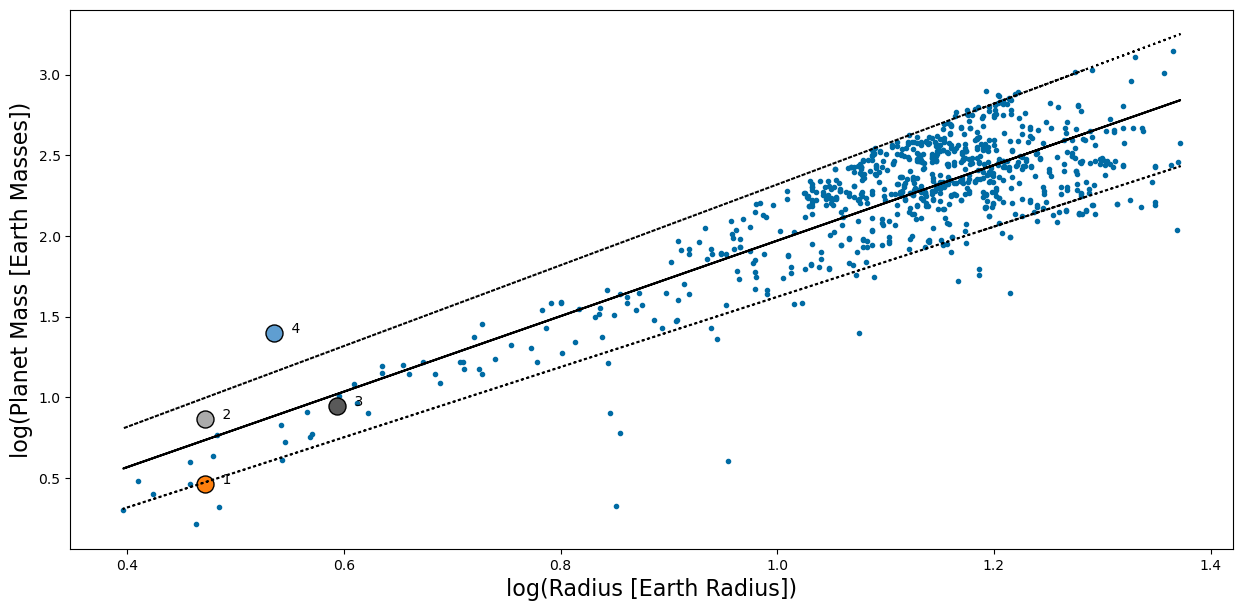

In [253]:
#Mass Radius Plot 
#Select all mini-neptune planets. 
#density < 1, sma < 0.5 

data = exodata_puff_filter

e_masses = data['pl_masse']
e_rads = data['pl_rade']
density = data['pl_dens']


plt.figure(figsize = (15, 7))
plt.style.use('tableau-colorblind10')


plt.scatter(lograd, logmass, ls = 'None', marker = '.' )
plt.scatter(np.log10(p1_rad), np.log10(p1_mass_e),  marker = 'o',s= 150, edgecolors = 'Black')
plt.scatter(np.log10(p2_rad), np.log10(p2_mass_e),  marker = 'o',s= 150, edgecolors = 'Black')
plt.scatter(np.log10(p3_rad), np.log10(p3_mass_e),  marker = 'o',s= 150, edgecolors = 'Black')
plt.scatter(np.log10(p4_rad), np.log10(p4_mass_e),  marker = 'o',s= 150, edgecolors = 'Black')
plt.text(np.log10(p1_rad), np.log10(p1_mass_e), '    1', ha = 'left')
plt.text(np.log10(p2_rad), np.log10(p2_mass_e), '    2', ha = 'left')
plt.text(np.log10(p3_rad), np.log10(p3_mass_e), '    3', ha = 'left')
plt.text(np.log10(p4_rad), np.log10(p4_mass_e), '    4', ha = 'left')



plt.plot(lograd, linfit(lograd,a, c),c='k',zorder=2,label='Model')
pylab.plot(lograd, linfit(lograd,a+(3*aerr),c+(3*cerr) ),c='k',ls='dotted',zorder=2)
pylab.plot(lograd, linfit(lograd,a-(3*aerr), c-(3*cerr)),c='k',ls='dotted',zorder=2)

plt.xlabel('log(Radius [Earth Radius])', fontsize = 16)
plt.ylabel('log(Planet Mass [Earth Masses])', fontsize = 16)
#plt.yscale('log')
#plt.xscale('log')

#plt.colorbar()

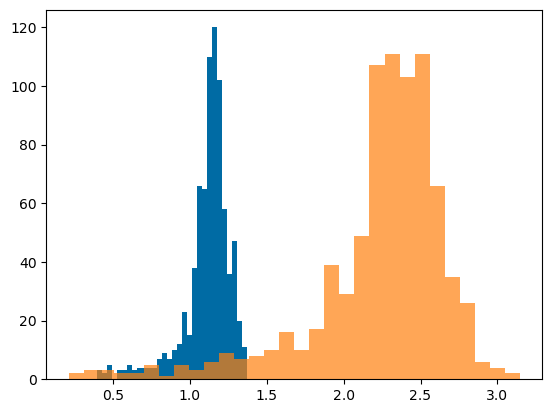

In [254]:

Rnum, Rbins, Rpatches = plt.hist(np.log10(e_rads),bins=30)

Mnum, Mbins, Mpatches = plt.hist(np.log10(e_masses), bins = 30, alpha = 0.7)

In [255]:
from scipy.stats import spearmanr

# Now let's calculate the spearman rank correficient
rank,sp_pvalue = spearmanr(lograd,logmass)

print('\033[1m' + "mass and radius have a Spearman's rank %.2f and p-value of %.2e" % (rank,sp_pvalue) + '\033[0m')


mass and radius have a Spearman's rank 0.60 and p-value of 7.75e-80


This figure shows the distribution of radii (blue) and corresponding masses(orange), neither the radii or the masses are normally distributed and therefore a non parametric spearman's rank test is used to test for correlation which outputs a spearman's rank of 0.6 suggesting that the two parameters are correlated the low p-value suggests that the null-hypothesis is very unlikely and therefore it can be concluded that there is indeed a slight correlation between the two values. 

In [256]:
Nan_rads = ~np.isnan(e_rads) 
Nan_masses = ~np.isnan(e_masses)

e_rads_new =e_rads[(Nan_rads)&(Nan_masses)]
e_masses_new = e_masses[(Nan_rads)&(Nan_masses)]

#### 3.2 Overall picture


In [257]:
import pandas as pd
exodata = pd.read_csv("ExoplanetArchiveData.csv", delimiter = ',', header = 147)
exodata_transit = exodata[exodata['discoverymethod'] == "Transit"]
exodata_kepler = exodata[exodata['pl_name'].str.contains('Kepler')]



/tmp/ipykernel_140/1757480929.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exodata = pd.read_csv("ExoplanetArchiveData.csv", delimiter = ',', header = 147)


Graph all data (A) or transit data (T) or just Kepler data(K)? T


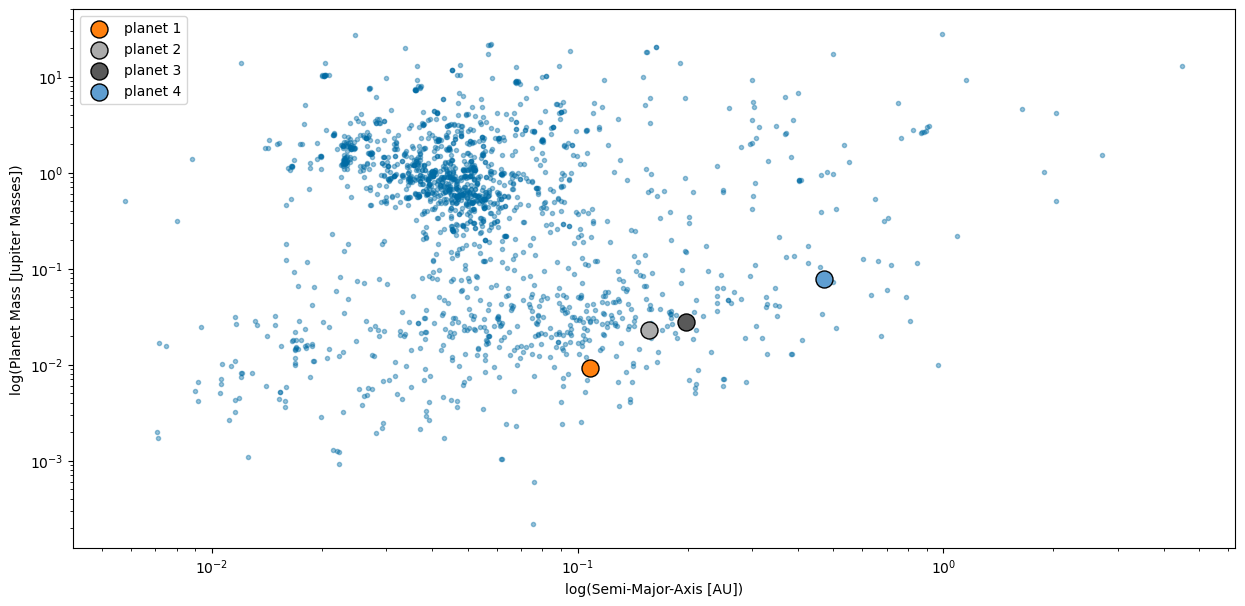

In [258]:
# To gain an understanding of planet formation we want to plot mass agains semi-major-axis. 
question = input("Graph all data (A) or transit data (T) or just Kepler data(K)? ")
if question == 'A':
    data = exodata
elif question == 'T':
    data = exodata_transit
elif question =='K':
    data = exodata_kepler
else:
    data = exodata

plt.figure(figsize = (15, 7))
plt.style.use('tableau-colorblind10')
jup_masses = data['pl_massj']
AU_sma = data['pl_orbsmax']
#density = np.log10(data['pl_dens'])

plt.scatter(AU_sma, jup_masses, ls = 'None', marker = '.', alpha = 0.4)
plt.xlabel('log(Semi-Major-Axis [AU])')
plt.ylabel('log(Planet Mass [Jupiter Masses])')
plt.yscale('log')
plt.xscale('log')

plt.scatter(p1_sma_AU, p1_mass_jup,  marker = 'o',s= 150, label = 'planet 1', edgecolors = 'Black')
plt.scatter(p2_sma_AU, p2_mass_jup, marker = 'o',s= 150, label = 'planet 2', edgecolors = 'Black')
plt.scatter(p3_sma_AU, p3_mass_jup, marker = 'o', s= 150, label = 'planet 3', edgecolors = 'Black')
plt.scatter(p4_sma_AU, p4_mass_jup, marker = 'o', s= 150, label = 'planet 4', edgecolors = 'Black')

#plt.colorbar()
plt.legend()

The four planets lie in the traditional core-accretion regime - however this does not take migration into account - which is discussed in the next section.  If T is chosen in the above simulation we can see that the exoplanets are a bit rarer than other finds of exoplanets due to the comparatively larger semi-major axis - this is explained as the transit method more easily detects exoplanets close to the star as described in the introduction. 

#### Planet Formation  

As described in section 3.1, the planets discovered in this paper can be described as being close in super-earths with short periods dissimilar to the planets seen in our solar system. 

Some of the main properties, which are derived from current population of discovered exoplanets and which must be matched by any formation model is as follows. One, a large fraction (1/3 to 1/2) of stars have close in super Earths with periods shorter than 100 days but many do not as well. Secondly, most super earth systems only have a single planet detected in transit - the system which is considered here is an exception to this. Thirdly the masses of the of super-Earths extend from earth to neptune with a preference for a few earth masses.  [5]

Raymond et al. (2008a) [6] proposed a model for the formation of super-earths before they were even discovered and this model was based on simple situ accretion. However it has a flaw as the masses in the innermost parts of the disks are not estimated to have enough mass for this to occur. In addition to this there is also a timescale issue at play here - there are high densities in the inner disk and so the growth timescale for super-earths would be so fast and the disk would have to be so massive that migration is simply unavoidable. Even drag is strong enough to cause orbital dift. Despite this, there is evidence to suggest that in the correct condition core accretion is still possible. 

Many of the first mdoels explored for forming super-earth's relied on giant planets - which are known to migrate inwards - as they do so they can shepherd material inwards and facilitate the growth of super giants. This theory was discarded as the main formation pathway as most super-earth systems do not appear to have a super giant companion. 

Therefore various scientists, (Chiang, Youdin 2010) [7] have used simulations to generate a 'minimum-mass extrasolar nebula' to represent a disk which would have formed the population of super-earths. These models incorporate inward migration of these planets and this is a successful model in predicting the observed planetary properties. 

In this model, large planetary embryos grow throughout the disk and migrate inward, driven by the gaseous disk. It is thought that the planets would first form past the snow line, where accretion is thought to be more efficient, but it also possible for accretion to occur closer to the star when a pebble is drifint inwards are concentrated at a pressure bump.

Another question which needs to be considered is that if super-earthformation is as efficient as is seen in simulations, as shown in [5] how come all stars do not have them? One possibility is that when an outer gas giant planets form, these block the the inwward migration of forming super earths and these instead become ice giants (Izidoro et al. 2015a, b). This implies that gas giants and super-Earth's should rarely be both present in a system and this is yet to be confirmed.

The model described here fits with that of the data. 

#### 3.6 Follow-up measurements 

This section goes through the follow up measurements which should be taken to allow a deeper understanding of the discovered exoplanets and their associated properties which can give more clues to the formation of the planetary system as well as discover more planets orbiting the host star. 

As  described by Ananyeva et al. 2020 [8], the RV method combined with the transit method is a powerful way to determine an accurate estimation of the mass of the planet, this is because the radial velocity method can measure the minimal mass as $m \cdot sin i$, where i is the inclination of the planetary orbit polar axis towards the observer. However, for a transiting planet one can safely assume that the angle is near 90 degrees and so the mass of the exoplanet m can be reliably determined. 

Note that in this report the mass is obtained via private communications but this needs to be confirmed. 

Another form of analysis which can be done is to measure the transit timing variation (TTV) between one transit and the next - these variations are caused by gravitational tugs that planets exert on each other and their host star. Therefore these measurements can be used to infer the presence of anotherr planet and determine its mass, size and orbit. Kepler 19-c was discovered by observing the transit timing variations of Kepler-19 b[9]. 

Finally a higher resolution telescope with a higher signal to noise can should be used to observe secondary transits which occur when the star blocks the light of the planet as it passes behind the star. In order to observe this effect the observations should be made at longer wavelengths as the planet will be cooler than the star and therefore emitting longer wavelengths. If these observations can be made then the temperature of the planets atmosphere (if it has one) can be determined. The equation for the temperature of the atmosphere is given by:
$
\begin{align}
\Delta F_{secondary} = (\frac{R_p}{R_*})^2 (\frac{T_p}{T_*}) \tag{4}
\end{align}
$
Where delta F is the change in flux of the secondary transit, $R_p$ is the radius of the planet $R_*$ is the radius of the star. $T_p$ and $T_*$ is the temperature of the planet and the star respectively. 

### 4. Summary



- Photometry was done on light curve data taken from the Kepler space telescope of a single star. 
- 4 planets are discovered and determined to be super-earths / mini-Neptunes. 
- Planet formation is determined to be through core accretion with inward migration explaining the close proximity of the planets with the star. 
- Planets have such low densities impying that they are mainly made up of gas. 


### References:

- [1] exoplanetarchive.ipac.caltech.edu. Planetary Systems. [online] Available at:https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS.
- [2] science.nasa.gov. Kepler / K2 - NASA Science. [online] Available at: https://science.nasa.gov/mission/kepler
- [3]  Li, M. and Xiao, L. (2016). LIFETIMES AND ACCRETION RATES OF PROTOPLANETARY DISKS. The Astrophysical Journal, 820(1), p.36. doi:https://doi.org/10.3847/0004-637x/820/1/36.
- [4] science.nasa.gov. Puffy Planets Lose Atmospheres, Become Super Earths - NASA Science. [online] Available at: https://science.nasa.gov/missions/hubble/puffy-planets-lose-atmospheres-become-super-earths [Accessed 18 Dec. 2023].
- [5] Raymond, S.N. and Morbidelli, A. (2022). Planet Formation: Key Mechanisms and Global Models. NASA ADS, [online] 466, pp.3–82. doi:https://doi.org/10.1007/978-3-030-88124-5_1.
- [6] Raymond, S.N., Barnes, R., Armitage, P.J. and Gorelick, N. (2008). Mean Motion Resonances from Planet-Planet Scattering. The Astrophysical Journal, 687(2), pp.L107–L110. doi:https://doi.org/10.1086/593301.
- [7] Chiang, E. and Youdin, A.N. (2010). Forming Planetesimals in Solar and Extrasolar Nebulae. Annual Review of Earth and Planetary Sciences, 38(1), pp.493–522. doi:https://doi.org/10.1146/annurev-earth-040809-152513.
- [8] Ananyeva, V.I., et al. (2020). Mass distribution of exoplanets considering some observation selection effects in the transit detection technique. Icarus, [online] 346, p.113773. doi:https://doi.org/10.1016/j.icarus.2020.113773.
[9] The Planetary Society. (n.d.). Timing Variations. [online] Available at: https://www.planetary.org/articles/timing-variations.

### Finally, exporting your Coursework

Finally, create a html file of your coursework as follows. This removes the code boxes.

<div class="alert alert-block alert-danger">
<b>You will still need to submit the full notebook and associated code files.</b>

In [262]:
!jupyter nbconvert --to html --no-input Planet_Formation_Model.ipynb

[NbConvertApp] Converting notebook Planet_Formation_Model.ipynb to html
[NbConvertApp] Writing 3187313 bytes to Planet_Formation_Model.html
